In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util import *

In [2]:
CHANNEL_MAPPING = {
    3: 'red',
    52: 'green',
    74: 'blue',
}

INVERSE_CHANNEL_MAPPING = {
    'red': 3,
    'green': 52,
    'blue': 74
}

CHANNEL_COLORS = {
    'red': 'red',
    'green': 'green',
    'blue': 'blue'
}

LABELS = {
    'red': '1567nm',
    'green': '1547nm',
    'blue': '1539nm'
}

directory = 'wdl'

In [3]:
timestamps, bers, fecs, powers = parse_transponder_data(f'../data/{directory}/transponder_data.csv')

In [4]:
postproc_bers = {}
postproc_fecs = {}
postproc_powers = {}

for wavelength, channel in INVERSE_CHANNEL_MAPPING.items():
    postproc_bers[wavelength] = bers[channel]
    postproc_fecs[wavelength] = fecs[channel]
    postproc_powers[wavelength] = powers[channel]

In [5]:
min_ts = min(timestamps)
ts_adjusted = [ts - min_ts for ts in timestamps]

In [6]:
first_fec_change = {}
for wavelength, fec_vals in postproc_fecs.items():
    initial_fec = fec_vals[0]
    for i in range(1, len(fec_vals)):
        if fec_vals[i] > initial_fec:
            first_fec_change[wavelength] = i
            break

In [7]:
first_fec_change_stop = {}

for wavelength, fec_vals in postproc_fecs.items():
    for i in range(first_fec_change[wavelength], len(fec_vals) - 5):
        if all(fec_vals[i] == fec_vals[i+j] for j in range(1, 6)):
            first_fec_change_stop[wavelength] = i
            break

In [8]:
layer3_times, layer3_vals = get_layer3_data(directory)

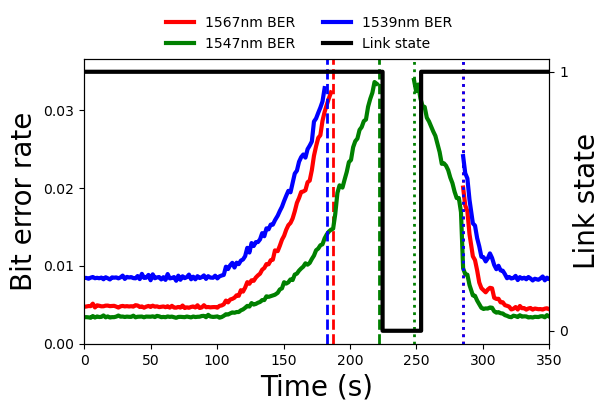

In [9]:
fig, ax = plt.subplots(figsize=(6,3.7))
ax2 = ax.twinx()

ax2.plot([layer3_time - min_ts for layer3_time in layer3_times], layer3_vals, color='black', label='Link state', lw=3)
for wavelength, vals in postproc_bers.items():
    # Between stable FEC values when the uncorrectable FEC counter is increasing, i.e., the link is failing, the hardware is unable to accurately calculate a BER, so we do not plot any data for this period
    ax.plot(ts_adjusted, [vals[i] if i < first_fec_change[wavelength] or i >= first_fec_change_stop[wavelength] else None for i in range(0, len(vals))], color=CHANNEL_COLORS[wavelength], label=LABELS[wavelength] + ' BER', lw=3)
    ax.axvline(x=ts_adjusted[first_fec_change[wavelength]], color=CHANNEL_COLORS[wavelength], linestyle='dashed', lw=2)
    ax.axvline(x=ts_adjusted[first_fec_change_stop[wavelength]], color=CHANNEL_COLORS[wavelength], linestyle='dotted', lw=2)

ax.set_xlabel('Time (s)', fontsize=20)
ax2.set_yticks([0,1])
ax.set_yticks([0, 0.01, 0.02, 0.03])
ax.set_ylabel('Bit error rate', fontsize=20)
ax2.set_ylabel('Link state', fontsize=20)

ax.set_xlim(0, 350)  # We did a random experiment with the variable optical after the bend experiments (post 350 s) -- we don't care about this data
fig.legend(bbox_to_anchor=(0.5, 0.95), loc='center', ncol=2, frameon=False)

plt.rcParams.update({'font.size': 14})
plt.show()

In [10]:
adjusted_powers = {}
for channel, vals in powers.items():
    adjusted_powers[channel] = [val - vals[0] for val in vals]

mean_loss = np.mean(list(adjusted_powers.values()), axis=0)

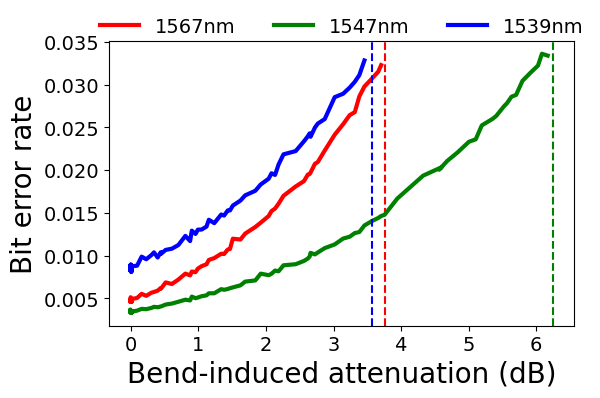

In [11]:
plt.figure(figsize=(6, 3.7))
for channel, vals in postproc_bers.items():
    plt.plot([-x for x in mean_loss], [vals[i] if i < first_fec_change[channel] else None for i in range(0, len(vals))], label=LABELS[channel], color=CHANNEL_COLORS[channel], lw=3)
    
    # Error in the x-axis ticks of the Fig. 4b because I instead plotted: plt.axvline(x=-mean_loss[first_fec_change[mod_format]] + 16, color=MOD_FORMAT_COLORS[mod_format], linestyle='dashed')
    # The + 16 was to add the fixed loss fron the 16 dB attenuator that was present from the very beginning. 
    # But this is incorrect, because you cannot add dB's since they are log scale. 
    # Instead, we just opt to plot the dB change from the bend to be more accurate.
    plt.axvline(x=-mean_loss[first_fec_change[channel]], color=CHANNEL_COLORS[channel], linestyle='dashed')

plt.rcParams.update({'font.size': 14})
plt.xlabel('Bend-induced attenuation (dB)', fontsize=20)
plt.ylabel('Bit error rate', fontsize=20)
plt.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=3, frameon=False)
plt.show()